<a href="https://colab.research.google.com/github/dgrifka/baseball_simulator_model/blob/main/Base_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import requests
import pandas as pd
import numpy as np
import json
from pandas import json_normalize
import time
from sqlalchemy import create_engine#, MetaData
import datetime
import pymysql

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import pickle
pd.set_option('display.max_columns', None)

Database info goes here

In [4]:
table_name = 'games'

# Read the data from the 'games' table, excluding 'Spring Training' and 'Exhibition' games
query = f"SELECT * FROM {table_name} WHERE seriesDescription NOT IN ('Spring Training', 'Exhibition') AND venue_name not in ('Gocheok Sky Dome', 'Estadio Alfredo Harp Helu','London Stadium', 'Muncy Bank Ballpark')"
games = pd.read_sql_query(query, engine)

# Get the unique 'gamePk' values from the filtered 'games' table
game_pks = games['gamePk'].unique()

games.head()

,gameDate,gameNumber,gamePk,gamesInSeries,last_updated_date,season,seriesDescription,sport_id,status_abstractGameState,teams_away_isWinner,teams_away_leagueRecord_losses,teams_away_leagueRecord_pct,teams_away_leagueRecord_wins,teams_away_score,teams_away_seriesNumber,teams_away_team_id,teams_home_isWinner,teams_home_leagueRecord_losses,teams_home_leagueRecord_pct,teams_home_leagueRecord_wins,teams_home_score,teams_home_seriesNumber,teams_home_team_id,venue_id,venue_name
0,2024-03-28 19:05:00,1,747060,3.0,2024-05-15 18:47:48,2024,Regular Season,1,Final,False,1,0.0,0,3.0,1.0,108,True,0,1.000,1,11.0,1.0,110,2,Oriole Park at Camden Yards
1,2024-03-28 20:10:00,1,746737,3.0,2024-05-15 18:47:48,2024,Regular Season,1,Final,False,1,0.0,0,2.0,1.0,120,True,0,1.000,1,8.0,1.0,113,2602,Great American Ball Park
2,2024-03-28 20:10:00,1,745445,4.0,2024-05-15 18:47:48,2024,Regular Season,1,Final,False,1,0.0,0,4.0,1.0,137,True,1,0.667,2,6.0,2.0,135,2680,Petco Park
3,2024-03-28 20:10:00,1,746165,4.0,2024-05-15 18:47:48,2024,Regular Season,1,Final,False,1,0.0,0,1.0,1.0,138,True,1,0.667,2,7.0,2.0,119,22,Dodger Stadium
4,2024-03-28 20:10:00,1,745116,4.0,2024-05-15 18:47:48,2024,Regular Season,1,Final,True,0,1.0,1,8.0,1.0,141,False,1,0.000,0,2.0,1.0,139,12,Tropicana Field


In [5]:
games['venue_name'].unique()

array(['Oriole Park at Camden Yards', 'Great American Ball Park',
       'Petco Park', 'Dodger Stadium', 'Tropicana Field',
       'Kauffman Stadium', 'Guaranteed Rate Field', 'loanDepot park',
       'Minute Maid Park', 'Globe Life Field', 'Oakland Coliseum',
       'Chase Field', 'T-Mobile Park', 'Citi Field', 'Citizens Bank Park',
       'Wrigley Field', 'Nationals Park', 'American Family Field',
       'Target Field', 'Busch Stadium', 'Yankee Stadium', 'Comerica Park',
       'Coors Field', 'PNC Park', 'Oracle Park', 'Truist Park',
       'Angel Stadium', 'Progressive Field', 'Rogers Centre',
       'Fenway Park'], dtype=object)

Since this table is large, we can break it into chunks to prevent Colab from crashing

In [6]:
table_name = 'game_info'
chunk_size = 100000

# Read the data from the 'game_info' table in chunks, filtering by the unique 'gamePk' values
# and excluding rows where 'hitData_launchSpeed' and 'hitData_launchAngle' are null
chunks = []
columns = ['playId', 'gamePk', 'eventType', 'hitData_launchSpeed', 'hitData_launchAngle']
for chunk in pd.read_sql_table(table_name, engine, chunksize=chunk_size, columns=columns):
    chunk = chunk[(chunk['gamePk'].isin(game_pks)) & (pd.notnull(chunk['hitData_launchSpeed'])) & (pd.notnull(chunk['hitData_launchAngle']))]
    chunks.append(chunk)

# Concatenate the chunks into a single DataFrame
game_info = pd.concat(chunks, ignore_index=True)

# Group by 'playId', 'gamePk', 'eventType' and calculate the average of 'hitData_launchSpeed' and 'hitData_launchAngle'
game_info_grouped = game_info.groupby(['playId', 'gamePk', 'eventType']).agg({
    'hitData_launchSpeed': 'mean',
    'hitData_launchAngle': 'mean'
}).reset_index()

## Then, filter to the last record of this occurrence, since each playId includes other irrelevant information, such as stolen bases, etc.
game_info_grouped = game_info_grouped.drop_duplicates(subset="playId", keep="last")

game_info_grouped.head()

,playId,gamePk,eventType,hitData_launchSpeed,hitData_launchAngle
0,000111b7-5c6b-49b2-a828-e3aea4020aac,718028,field_out,100.0,-33.0
1,0001b643-8a44-41e0-aef1-4dffecc9c228,716405,single,95.0,4.0
2,0001c67c-853e-444f-af5c-24f9e35c0262,745419,field_out,96.5,43.0
3,00026cc6-aaab-40a2-95e5-c4f2ed8c80d4,717669,field_out,105.3,9.0
4,0002a80b-edd4-48da-998b-d730a6fb4d9c,716715,field_out,80.8,-46.0


In [ ]:
game_info.columns

Index(['ab_num', 'gamePk', 'eventType', 'rbi', 'awayScore', 'homeScore',
       'isOut', 'isTopInning', 'inning', 'season', 'startTime', 'endTime',
       'isComplete', 'isScoringPlay', 'hasOut', 'captivatingIndex', 'balls',
       'strikes', 'outs', 'batter_id', 'batSide_code', 'pitcher_id',
       'pitchHand_code', 'postOnFirst_id', 'splits_menOnBase',
       'postOnSecond_id', 'postOnThird_id', 'details_eventType',
       'details_runner_id', 'details_isScoringEvent', 'details_rbi',
       'details_earned', 'details_playIndex', 'details_responsiblePitcher_id',
       'isPitch', 'details_awayScore', 'details_homeScore', 'count_balls',
       'count_strikes', 'count_outs', 'playId', 'pitchNumber',
       'details_call_description', 'details_ballColor', 'details_isInPlay',
       'details_isStrike', 'details_isBall', 'pitchData_strikeZoneTop',
       'pitchData_strikeZoneBottom', 'pitchData_coordinates_x',
       'pitchData_coordinates_y', 'details_type_code',
       'details_type_desc

In [ ]:
game_info['eventType'].unique()

array(['walk', 'single', 'hit_by_pitch', 'double', 'strikeout',
       'home_run', 'field_out', 'force_out', 'grounded_into_double_play',
       'field_error', 'sac_fly', 'triple', 'fielders_choice',
       'catcher_interf', 'other_out', 'caught_stealing_2b', 'pickoff_1b',
       'fielders_choice_out', 'double_play', 'strikeout_double_play',
       'pickoff_caught_stealing_2b', 'pickoff_2b', 'wild_pitch',
       'caught_stealing_home', 'sac_bunt', 'caught_stealing_3b',
       'pickoff_caught_stealing_3b', 'game_advisory',
       'sac_fly_double_play', 'pickoff_3b', 'stolen_base_3b',
       'intent_walk', 'stolen_base_2b', 'pickoff_caught_stealing_home',
       'triple_play', 'runner_double_play', 'balk', 'pickoff_error_3b'],
      dtype=object)

For this we only care about batted balls, but for the simulation we want to marry batted balls with runners on base.

In [7]:
filtered_game_info = game_info_grouped.copy()
filtered_game_info = filtered_game_info[['gamePk', 'eventType', 'hitData_launchSpeed', 'hitData_launchAngle']]

# Create a list of event types that (should) result in an out
out_events = ['field_out', 'force_out', 'grounded_into_double_play', 'field_error', 'sac_fly',
              'fielders_choice', 'fielders_choice_out', 'double_play', 'sac_bunt']

# Replace event types that are not 'single', 'double', 'triple', or 'home_run' with 'out'
filtered_game_info['eventType'] = filtered_game_info['eventType'].apply(lambda x: x if x in ['single', 'double', 'triple', 'home_run'] else 'out')

# Remove rows where 'hitData_launchSpeed' and 'hitData_launchAngle' are NA
filtered_game_info = filtered_game_info[~filtered_game_info[['hitData_launchSpeed', 'hitData_launchAngle']].isna().any(axis=1)]

filtered_game_info.reset_index(drop=True, inplace=True)
## Include venue information, since this affects batted ball data
filtered_game_info = pd.merge(filtered_game_info, games[['gamePk', 'venue_name']], on = ['gamePk'], how = 'left')
filtered_game_info.head()

,gamePk,eventType,hitData_launchSpeed,hitData_launchAngle,venue_name
0,718028,out,100.0,-33.0,American Family Field
1,716405,single,95.0,4.0,Coors Field
2,745419,out,96.5,43.0,Petco Park
3,717669,out,105.3,9.0,Great American Ball Park
4,716715,out,80.8,-46.0,Nationals Park


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer

# Define a mapping of event types to numerical values
event_type_mapping = {
    'out': 0,
    'single': 1,
    'double': 2,
    'triple': 3,
    'home_run': 4
}

# Map the event types to numerical values
filtered_game_info['eventType_numeric'] = filtered_game_info['eventType'].map(event_type_mapping)

# Prepare the features and target variables
X = filtered_game_info[['hitData_launchSpeed', 'hitData_launchAngle', 'venue_name']]
y = filtered_game_info['eventType_numeric']


## Convert column names to strings
X.columns = [str(col) for col in X.columns]

numeric_features = ['hitData_launchSpeed', 'hitData_launchAngle']
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), ['venue_name']),
    remainder='passthrough'
)

# Fit the preprocessor on the feature matrix X and transform the data
X_preprocessed = preprocessor.fit_transform(X)

# Split the preprocessed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Create and train the Multinomial Logistic Regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2500)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Save the trained model and fitted preprocessor
with open('logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(model, file)

with open('preprocessor.pkl', 'wb') as file:
    pickle.dump(preprocessor, file)

Accuracy: 0.6824360051009299
Precision: 0.766458548090947
Recall: 0.6824360051009299
F1-score: 0.5669591719646093


In [9]:
from google.colab import files
files.download('preprocessor.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
from google.colab import files
files.download('logistic_regression_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
import pickle
import pandas as pd
import itertools

# Load the saved model
with open('logistic_regression_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Define the mapping of numerical values back to event types
numeric_event_mapping = {
    0: 'out',
    1: 'single',
    2: 'double',
    3: 'triple',
    4: 'home_run'
}

# Define the list of venue names to test
venue_names = ['Tropicana Field']

# Get the unique values of 'hitData_launchSpeed' and 'hitData_launchAngle'
launch_speeds = filtered_game_info['hitData_launchSpeed'].unique()
launch_angles = filtered_game_info['hitData_launchAngle'].unique()

# Create lists to store the values
speed_list = []
angle_list = []
venue_list = []
event_type_list = []
prob_out_list = []
prob_single_list = []
prob_double_list = []
prob_triple_list = []
prob_home_run_list = []

# Create a list of all possible combinations of launch speed, launch angle, and venue name
new_examples = []
for speed, angle, venue in itertools.product(launch_speeds, launch_angles, venue_names):
    example = {
        'hitData_launchSpeed': speed,
        'hitData_launchAngle': angle,
        'venue_name': venue
    }
    new_examples.append(example)

# Convert the new examples to a DataFrame
new_data = pd.DataFrame(new_examples)

# Preprocess the new examples using the same preprocessor
new_data_preprocessed = preprocessor.transform(new_data)

# Make predictions and get predicted probabilities
predictions = loaded_model.predict(new_data_preprocessed)
probabilities = loaded_model.predict_proba(new_data_preprocessed)

# Append the values to the lists
for example, prediction, probs in zip(new_examples, predictions, probabilities):
    speed_list.append(example['hitData_launchSpeed'])
    angle_list.append(example['hitData_launchAngle'])
    venue_list.append(example['venue_name'])
    event_type_list.append(numeric_event_mapping[prediction])
    prob_out_list.append(probs[0])
    prob_single_list.append(probs[1])
    prob_double_list.append(probs[2])
    prob_triple_list.append(probs[3])
    prob_home_run_list.append(probs[4])

# Create a DataFrame with the specified columns
result_df = pd.DataFrame({
    'hitData_launchSpeed': speed_list,
    'hitData_launchAngle': angle_list,
    'venue_name': venue_list,
    'event_type': event_type_list,
    'prob_out': prob_out_list,
    'prob_single': prob_single_list,
    'prob_double': prob_double_list,
    'prob_triple': prob_triple_list,
    'prob_home_run': prob_home_run_list
})

# Print the resulting DataFrame
print(result_df)

        hitData_launchSpeed  hitData_launchAngle       venue_name event_type  \
0                     100.0                -33.0  Tropicana Field        out   
1                     100.0                  4.0  Tropicana Field        out   
2                     100.0                 43.0  Tropicana Field        out   
3                     100.0                  9.0  Tropicana Field        out   
4                     100.0                -46.0  Tropicana Field        out   
...                     ...                  ...              ...        ...   
230951                 28.4                -75.0  Tropicana Field        out   
230952                 28.4                -83.0  Tropicana Field        out   
230953                 28.4                 89.0  Tropicana Field        out   
230954                 28.4                 90.0  Tropicana Field        out   
230955                 28.4                -90.0  Tropicana Field        out   

        prob_out  prob_single  prob_dou

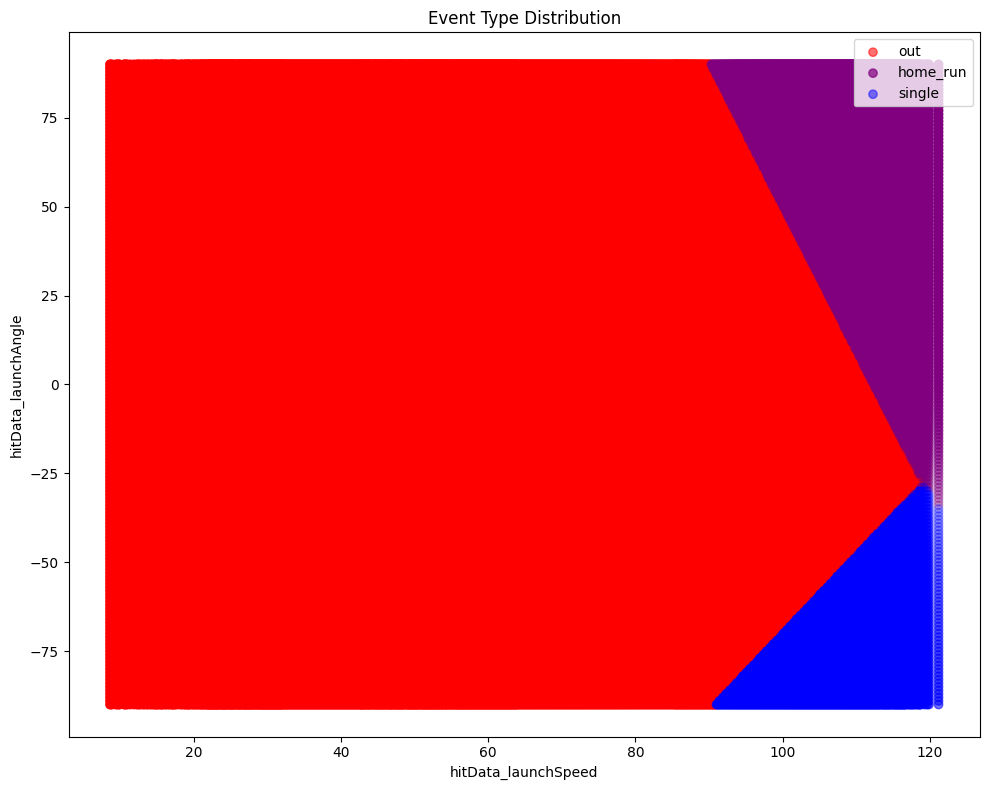

In [12]:
import matplotlib.pyplot as plt

# Create a dictionary mapping event types to colors
color_mapping = {
    'out': 'red',
    'single': 'blue',
    'double': 'green',
    'triple': 'orange',
    'home_run': 'purple'
}

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Iterate over each unique event type and plot the corresponding data points
for event_type in result_df['event_type'].unique():
    event_data = result_df[result_df['event_type'] == event_type]
    probabilities = event_data[f'prob_{event_type}']
    ax.scatter(event_data['hitData_launchSpeed'], event_data['hitData_launchAngle'],
               color=color_mapping[event_type], label=event_type, alpha=probabilities)

# Set the labels and title
ax.set_xlabel('hitData_launchSpeed')
ax.set_ylabel('hitData_launchAngle')
ax.set_title('Event Type Distribution')

# Add a legend with a fixed location
ax.legend(loc='upper right')  # Specify the location of the legend, e.g., 'upper right', 'lower left', etc.

# Display the plot
plt.tight_layout()
plt.show()